<a href="https://colab.research.google.com/github/SighOfFrostmourne/ECOM6022/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Python ≥3.5 and Scikit-Learn ≥0.20 are required
import sys
import sklearn
import numpy as np
import os

# To plot pretty figures (for report etc)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
ROOT_PATH = "/content/drive/MyDrive/ECOM6022/Assignment_2"
os.chdir(ROOT_PATH)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Assignment_2"
DATA_PATH = os.path.join(ROOT_PATH, "datasets")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##Read the downloaed file from Google Drive

As moodle requires authorization to download the file, download link url doesn't work properly from the original coding introduced in Lecture. Thus download it and use directly.

In [71]:
import pandas as pd

def load_data(data_path=DATA_PATH):
    train_csv_path = os.path.join(data_path, "mortgage_loan_train.csv")
    test_csv_path = os.path.join(data_path, "mortgage_loan_test.csv")
    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)

train_data, test_data = load_data() 

## Take a Quick Look at the Data Structure

In [ ]:
train_data.head()

In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_owner      1000 non-null   int64  
 1   monthly_income  1000 non-null   int64  
 2   debt_to_income  1000 non-null   float64
 3   fico_score      1000 non-null   int64  
 4   loan_status     1000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 39.2 KB


In [54]:
train_data.describe()

,home_owner,monthly_income,debt_to_income,fico_score,loan_status
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.608000,44038.046000,18.027300,695.990000,0.805000
std,0.488441,35108.230931,8.211567,32.119333,0.396399
min,0.000000,8424.000000,0.000000,660.000000,0.000000
25%,0.000000,26325.000000,12.047500,670.000000,1.000000
50%,1.000000,37440.000000,17.425000,690.000000,1.000000
75%,1.000000,52650.000000,23.485000,710.000000,1.000000
max,1.000000,585000.000000,40.520000,835.000000,1.000000


## Visualizing Geographical Data & Looking for Correlations


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

mortgage_train = train_data.copy()
mortgage_train.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [ ]:
corr_matrix = mortgage_train.corr()
corr_matrix["loan_status"].sort_values(ascending=False)

from pandas.plotting import scatter_matrix
attributes = ["home_owner", "monthly_income", "debt_to_income", "loan_status"]
scatter_matrix(mortgage_train[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# Prepare the Data for Machine Learning Algorithms

## Divide data and label

In [74]:
x_train = train_data.drop("loan_status", axis=1)
y_train = (train_data["loan_status"].copy() == 1)

x_test = test_data.drop("loan_status", axis=1)
y_test = (test_data["loan_status"].copy() == 1)

## Transformation Pipelines

Data Cleaning + Standardization

There is actually no need to do data cleaning this time as seen from info there's no missing data from the original file. But there's no harm defining here for re-use as it runs only for misssing ones.

In [75]:
# Transformation pipelines make it clean and also clear for reusability
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

x_train_std = num_pipeline.fit_transform(x_train)
x_test_std = num_pipeline.fit_transform(x_test)

## Training and Evaluating on the Training Set

There is no non-num attributes, thus height_train_tr is ready for traning!

In [76]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

#from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score

sgd_clf = SGDClassifier(random_state=42)
y_train_pred = cross_val_predict(sgd_clf, x_train_std, y_train, cv=3)

In [77]:
confusion_matrix(y_train, y_train_pred)

array([[  9, 186],
       [ 25, 780]])

In [78]:
recall_score(y_train, y_train_pred)

0.968944099378882

In [79]:
precision_score(y_train, y_train_pred)

0.8074534161490683

In [80]:
# Extract the precisions, recalls and thresholds data from precision_recall_curve()
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, x_train_std, y_train, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Saving figure precision_recall_vs_threshold_plot


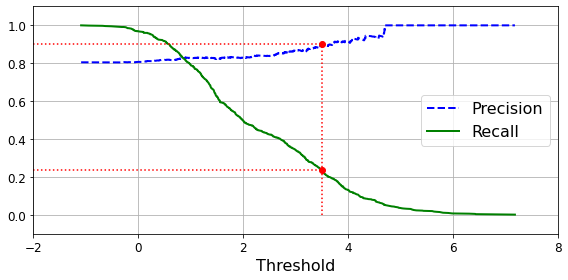

In [81]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-2, 8, -0.1, 1.1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-2, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-2, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Saving figure precision_vs_recall_plot


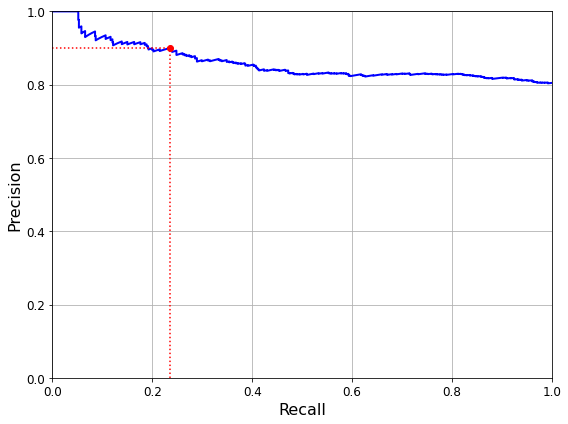

In [82]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

## The ROC Curve (*Receiver Operation Characteristic Curve*)

Saving figure roc_curve_plot


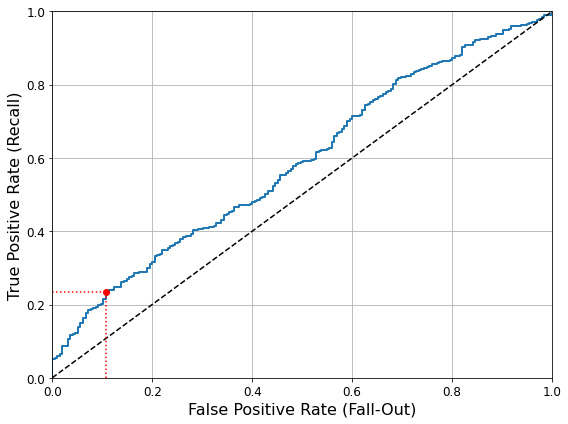

In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [84]:
roc_auc_score(y_train, y_scores)

0.5866475553432076

Saving figure roc_curve_comparison_plot


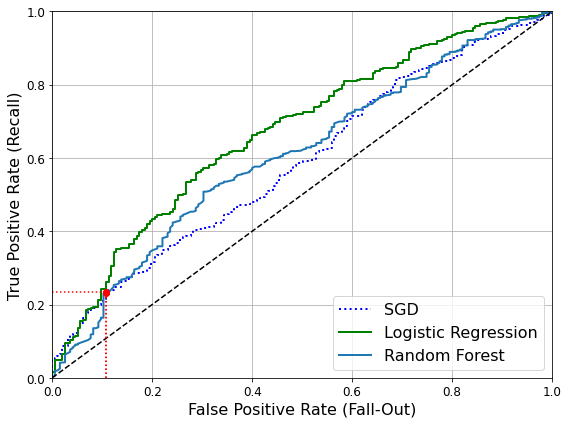

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#random forest
forest_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train_std, y_train, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

#logistic regression
lr_clf = LogisticRegression(random_state=42)
y_probas_lr = cross_val_predict(lr_clf, x_train_std, y_train, cv=3,
                                    method="predict_proba")
y_scores_lr = y_probas_lr[:, 1] # score = proba of positive class
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train,y_scores_lr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt.plot(fpr_lr, tpr_lr, "g-", linewidth=2, label = "Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [90]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train_std, y_train, cv=3)
y_train_pred_lr = cross_val_predict(lr_clf,x_train_std, y_train, cv=3)
accuracy_forest = precision_score(y_train, y_train_pred_forest)
sensitivity_forest = recall_score(y_train, y_train_pred_forest)

accuracy_lr = precision_score(y_train, y_train_pred_lr)
sensitivity_lr = recall_score(y_train, y_train_pred_lr)

print("forest accuracy", accuracy_forest)
print("forest sensitivity", sensitivity_forest)
print("logistic regression accuracy", accuracy_lr)
print("logistic regression sensitivity", sensitivity_lr)

forest accuracy 0.816414686825054
forest sensitivity 0.9391304347826087
logistic regression accuracy 0.8064516129032258
logistic regression sensitivity 0.9937888198757764


In [87]:
roc_auc_score(y_train, y_scores_forest)

0.6077719382067208

In [88]:
roc_auc_score(y_train, y_scores_lr)

0.671323459149546

In [ ]:
# random search logistic regression model
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=42)
# execute search
result = search.fit(x_train_std, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [92]:
#{'C': 0.0059892483184825155, 'penalty': 'l2', 'solver': 'newton-cg'}
lr_clf_best = LogisticRegression(penalty="l2",solver="newton-cg", C=0.0059892483184825155)
y_probas_lr_best = cross_val_predict(lr_clf_best, x_train_std, y_train, cv=3,
                                    method="predict_proba")
y_scores_lr_best = y_probas_lr[:, 1] # score = proba of positive class
roc_auc_score(y_train, y_scores_lr_best)

0.671323459149546

In [95]:
y_train_pred_lr_best = cross_val_predict(lr_clf_best, x_train_std, y_train, cv=3)
recall_score(y_train, y_train_pred_lr_best)

1.0

###Working on Test data set

As Rrandom forest model has higher scores than SGD, here we choose RF as our model to work on

Saving figure roc_curve_comparison_plot


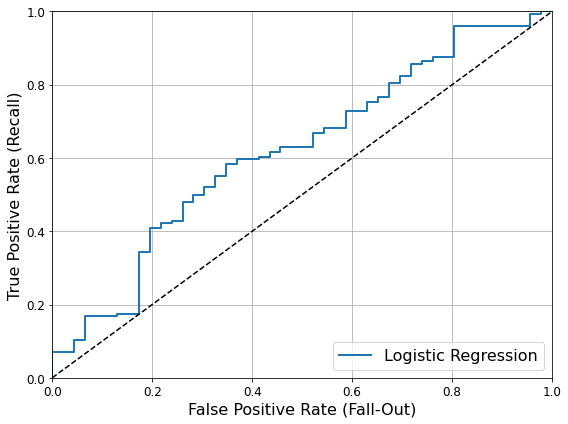

In [99]:
lr_clf = LogisticRegression()
final_model = lr_clf.fit(x_train_std,y_train)
final_probas = final_model.predict_proba(x_test_std)
final_scores = final_probas[:,1]
fpr_lr_final, tpr_lr_final, thresholds_lr_final = roc_curve(y_test,final_scores)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lr_final, tpr_lr_final, "Logistic Regression")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [100]:
y_test_pred_lr = cross_val_predict(final_model,x_test_std, y_test)

accuracy_lr_final = precision_score(y_test, y_test_pred_lr)
sensitivity_lr_final = recall_score(y_test, y_test_pred_lr)

print("logistic regression accuracy", accuracy_lr_final)
print("logistic regression sensitivity", sensitivity_lr_final)

logistic regression accuracy 0.77
logistic regression sensitivity 1.0


In [ ]:
y_test_pred_lr

In [101]:
roc_auc_score(y_test, final_scores)

0.6191417278373801